In [8]:
import PIL
import numpy as np
import hopfield as hf
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
from IPython.display import HTML, display
from IPython.display import Image,display
import cv2
from tqdm import tqdm
def noise(src: np.ndarray, p, binary = False):
    d = src.copy()
    for r in range(int(p*len(d))):
        i = np.random.randint(len(d))
        if binary:
            d[i] = np.random.randint(0,2)
        else:
            d[i] = np.random.randint(0,2)*2-1
    return d.copy()

### Generation and test settings

In [9]:
N = 36 # neurons count
M = 4 # images count
size = int(N**0.5)
images = np.array([np.random.randint(0,2,N)*2-1 for j in range(M)],np.float16) #generated images
noise_range = (0, 0.4, 4) # noise level from 0 ot 40%
mu_range = (0,1,10) # m
timeout = 250
gens_per_image = 20 # 20 noised images generated for testing
print("Images/neurons ratio:", M/N)

Images/neurons ratio: 0.1111111111111111


Memorized images:


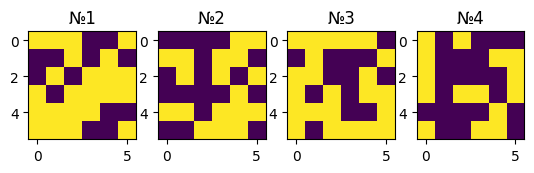

In [10]:
fig, axs = plt.subplots(1,M)
print("Memorized images:")
for j in range(M):
    axs[j].imshow(images[j].reshape(size,size))
    axs[j].set_title("№"+str(j+1))

# Testing:
Test Results:
"+1" - positive, "-1" - negative, "0"  - timeout negative.

In [11]:
noize_val = np.linspace(*noise_range)
mu_val = np.linspace(*mu_range)

net = hf.Hopfield()
net.train(images)

sync_test_result= np.zeros((M,len(noize_val),gens_per_image, len(mu_val)),np.int8)

for img_i in tqdm(range(M)):
    for p_i in range(len(noize_val)):
        for gen in range(gens_per_image):
            test_image = noise(images[img_i], noize_val[p_i])
            for mu_i in range(len(mu_val)):
                time, out = net.run(test_image, timeout,"sync",mu_val[mu_i])
                if (out==images[img_i]).all():
                    sync_test_result[img_i,p_i,gen, mu_i]=1
                elif time==timeout:
                    sync_test_result[img_i,p_i, gen, mu_i]=0
                else:
                    sync_test_result[img_i,p_i,gen, mu_i]=-1

100%|██████████| 4/4 [00:44<00:00, 11.14s/it]


# Test results

#### Average on all images:

Noise: 0.26666666666666666


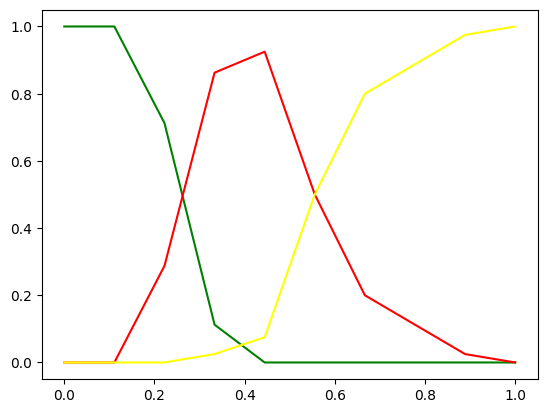

In [12]:
p_index = 2

print("Noise:", noize_val[p_index])

n = sync_test_result[:,0,:,0].size
rng = np.linspace(0,1,mu_range[2])
true = [(sync_test_result[:,p_index,:,j]==1).sum()/n for j in range(len(mu_val))]
false = [(sync_test_result[:,p_index,:,j]==-1).sum()/n for j in range(len(mu_val))]
timeout_false = [(sync_test_result[:,p_index,:,j]==0).sum()/n for j in range(len(mu_val))]

plt.plot(rng,true,color="green")
plt.plot(rng,false,color="red")
plt.plot(rng,timeout_false,color="yellow")
plt.plot(0)
plt.plot(0.5)

#### Average on each image:

Noise: 0.26666666666666666


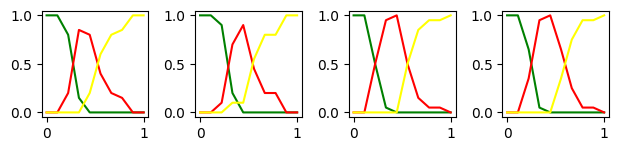

In [13]:
p_index = 2
print("Noise:", noize_val[p_index])
n = sync_test_result[0,0,:,0].size
rng = np.linspace(0,1,mu_range[2])
fig, axs = plt.subplots(1,M)

for i in range(M):
    fig.tight_layout()
    axs[i].set_adjustable('box')
    axs[i].set_aspect(1, adjustable='box')
    true = [(sync_test_result[i,p_index,:,j]==1).sum()/n for j in range(len(mu_val))]
    false = [(sync_test_result[i,p_index,:,j]==-1).sum()/n for j in range(len(mu_val))]
    timeout_false = [(sync_test_result[i,p_index,:,j]==0).sum()/n for j in range(len(mu_val))]
    axs[i].plot([0,0],[1,1])
    axs[i].plot(rng,true,color="green")
    axs[i].plot(rng,false,color="red")
    axs[i].plot(rng,timeout_false,color="yellow")

## Random prediction example:

True


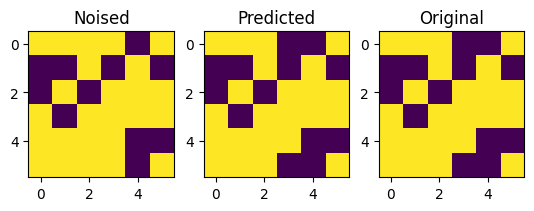

In [14]:
i=np.random.randint(0,M)
t = noise(images[i], 0.2)
e,out = net.run(t,250,"sync",0)
fig, axs = plt.subplots(1,3)
axs[0].imshow(t.reshape(size,size))
axs[0].set_title("Noised")
axs[1].imshow(out.reshape(size,size))
axs[1].set_title("Predicted")
axs[2].imshow(images[i].reshape(size,size))
axs[2].set_title("Original")
print((out==images[i]).all())